## Import Packages

In [9]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mimg
import numpy as np
from numpy import pi as PI
import math
import cv2
import os
from moviepy.editor import VideoFileClip
%matplotlib inline

## Read in an image

In [2]:
image = mimg.imread('test_images/solidWhiteRight.jpg')
print('Image dimensions ', image.shape)

Image dimensions  (540, 960, 3)


## Encapsulatiion of Lane and Line Segments

In [3]:
class Lane(object):
    """ Encapsulation of a lane's properties."""

    # Static fields.
    LEFT_LINE = 'left'
    RIGHT_LINE = 'right'
    APPROX_HORIZONTAL_LINE_SLOPE = 0.4


class Line(object):
    """ Represents a 2D line-segment in Euclidean coordinate system."""

    def __init__(self, x1, y1, x2, y2):
        # Ordering the endpoints from left to right as in a traditional xy coordinate system viewpoint.
        if x1 > x2:
          (x1, y1), (x2, y2) = (x2, y2), (x1, y1)
        self.x1, self.y1 = x1, y1
        self.x2, self.y2 = x2, y2
        self.slope = self.calculate_slope()
        self.intercept = self.calculate_intercept()
        # Tells which part of the lane-side this this line-segment belongs to, based on its slope.
        self.lane_side = self.filter_lane_line_side()

    def __repr__(self):
        return "x1={} y1={} x2={} y2={} slope={} y-intercept={}".format(self.x1, self.y1, self.x2, self.y2, self.slope,
                                                                    self.intercept)

    def calculate_slope(self):
        """ Calculates slope of a line."""
        if abs(self.x2 - self.x1) == 0:
            return math.inf
        return (self.y2 - self.y1) / (self.x2 - self.x1)

    def calculate_intercept(self):
        """ Calculates the y-intercept of a line."""
        return self.y1 - self.slope * self.x1

    def filter_lane_line_side(self):
        if self.slope < 0.0:
            return Lane.LEFT_LINE
        else:
            return Lane.RIGHT_LINE

    def get_endpoint_x_coordinates(self):
        return [self.x1, self.x2]

    def get_endpoint_y_coordinates(self):
        return [self.y1, self.y2]

    @property
    def is_candidate(self):
        """
        Checks whether a line-segment is a good candidate for a given lane-line (left or right).
        If the line-segment's slope is closer to a horizontal line's, then it is ignored.
        :return: Boolean value of a line-segment being a candidate.
        """
        if abs(self.slope) < Lane.APPROX_HORIZONTAL_LINE_SLOPE:
            return False
        return True

## Threshold constants

In [4]:
# Image resolution when converted from a video.
IMAGE_WIDTH = 960
IMAGE_HEIGHT = 540

# Color ranges in HSV space for yellow and white colors.
YELLOW_WHITE_COLOR_RANGE = ([0, 0, 210], [255, 255, 255])

# Gaussian blur.
GAUSSIAN_BLUR_KERNEL_SIZE = 3

# Canny edge detector's thresholds.
CANNY_LOW_THRESHOLD = 50
CANNY_HIGH_THRESHOLD = 170

# Region of interest vertices : 4-sided polygon.
ROI_BOTTOM_LEFT_X = 140
ROI_TOP_LEFT = (450,320)
ROI_TOP_RIGHT = (510,320)
ROI_BOTTOM_RIGHT_X = 880

# Hough transform parameters.
HOUGH_RHO = 1
HOUGH_THETA = PI/180
HOUGH_NUM_VOTES_THRESHOLD = 8
HOUGH_MIN_LINE_LENGTH = 10
HOUGH_MAX_LINE_GAP = 3

## Helper functions

Below helper functions are used as part of the lane-detection pipeline.

In [5]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    Note: This function has been modified to return just the raw line-segments identified while applying Hough transform.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    filtered_lines = list(filter(lambda l: l.is_candidate, map(lambda line: Line(*line[0]), lines)))
    if filtered_lines is not None:
        return filtered_lines
    else:
        return None
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def draw_lane_lines(img, left_line_pts, right_line_pts, color=[255,0,0], thickness=8):
    """
    Draws left and right lane lines on an image.
    :param img: Source image on which the lane-lines have to be drawn.
    :param left_line_endpoints: Endpoints of the line-segment belonging to the left line of the lane.
    :param right_line_endpoints: Endpoints os the line-segment belonging to the right line of the lane.
    :param color: RGB color of the line to be drawn.
    :param thickness: Thickness of the line to be drawn.
    """
    # Draw left line of the lane.
    cv2.line(img, left_line_pts[0], left_line_pts[-1], color, thickness)
    # Draw right line of the lane.
    cv2.line(img, right_line_pts[0], right_line_pts[-1], color, thickness)

def draw_lane(img, line_segments):
    """
    Segregates line-segments based on their slope to identify which part (left or right) of the lane they belong to.
    Runs a linear-regression on the identified left and right line-segments, and extrapolates those lines until the bottom
    part of the image i.e. x = 0 for left lane-line and y = height-of-image for right lane-line.
    :param line_segments:  Line segments obtained using Hough transform.
    :return:  Image containing marked lanes.
    """
    # Line fit on obtained hough-lines.
    if line_segments is not None:
        left_line_segments = [segment for segment in line_segments if segment.lane_side == Lane.LEFT_LINE]
        right_line_segments = [segment for segment in line_segments if segment.lane_side == Lane.RIGHT_LINE]
        left_line_x, left_line_y = get_x_y_coordinates_as_list(left_line_segments)
        right_line_x, right_line_y = get_x_y_coordinates_as_list(right_line_segments)

    if len(left_line_x) == 0 or len(left_line_y) == 0 or len(right_line_x) == 0 or len(right_line_y) == 0:
        return None

    left_coeffs = np.polyfit(left_line_x, left_line_y, 1)
    right_coeffs = np.polyfit(right_line_x, right_line_y, 1)

    left_line = np.poly1d(left_coeffs)
    right_line = np.poly1d(right_coeffs)

    # Generate left-line and right-line's points.
    # Note: Minimum x-coordinate that can be observed is 0.
    x_left = np.linspace(0, max(left_line_x), 10).astype(int)
    y_left = left_line(x_left).astype(int)
    left_line_pts = list(zip(x_left, y_left))
    # Note: Maximum x-coordinate that can be observed is image's width.
    x_right = np.linspace(min(right_line_x), img.shape[1], 10).astype(int)
    y_right = right_line(x_right).astype(int)
    right_line_pts = list(zip(x_right, y_right))

    lines_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lane_lines(lines_img, left_line_pts, right_line_pts)
    return lines_img

def get_x_y_coordinates_as_list(line_segments):
    """
    Returns x-coordinates and y-coordinates as separate lists.
    :param line_segments: Line segments containing x and y coordinates.
    """
    line_x_coords = []
    line_y_coords = []

    for line_seg in line_segments:
        line_x_coords += line_seg.get_endpoint_x_coordinates()
        line_y_coords += line_seg.get_endpoint_y_coordinates()

    return line_x_coords,line_y_coords

def write_img(img, path=os.getcwd()+'/processed_lane.jpg'):
    """

    :param img: Source image to be saved.
    :param path: File path of the image to be saved.
    :return: None.

    NOTE: The color channels are flipped i.e. RGB -> BGR while writing an image to a file.
    """
    cv2.imwrite(path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR), [cv2.IMWRITE_JPEG_QUALITY,95])

## Detection pipeline

In [6]:
def detect_lanes_pipeline(actual_image):
    """
    Runs the lane-detection pipeline on a given image.
    :param actual_image:  Image in which the lanes have to be found.
    :return:  Image having marked lanes.
    """
    height,width,num_channels = actual_image.shape

    # Get grayscale image.
    gray = grayscale(actual_image)
    
    # Plotting the histogram gives us an idea about the gradient intensities which then helps to setting the lower/upper
    # thresholds during Canny filter step.
    # plt.hist(gray.ravel(),256,[0,256])

    # Remove noise using Gaussian blur.
    gray_denoised = gaussian_blur(gray, GAUSSIAN_BLUR_KERNEL_SIZE)

    # Get image containing edges.
    edges = canny(gray_denoised, CANNY_LOW_THRESHOLD, CANNY_HIGH_THRESHOLD)

    # Clip the region containing the current lane.
    clipped_image = region_of_interest(edges,
                                        np.array([[(ROI_BOTTOM_LEFT_X,height), ROI_TOP_LEFT, ROI_TOP_RIGHT,
                                        (ROI_BOTTOM_RIGHT_X,height)]], dtype=np.int32))

    # Run a Hough transform on the image containing the edges to find line segments belonging to the lane's lines.
    line_segments = hough_lines(clipped_image, HOUGH_RHO, HOUGH_THETA, HOUGH_NUM_VOTES_THRESHOLD,
                         HOUGH_MIN_LINE_LENGTH, HOUGH_MAX_LINE_GAP)

    # Draw Hough-lines on the actual image.
    lane_image = draw_lane(clipped_image, line_segments)

    # Return an image with lane-lines, if found, overlayed on the actual image.
    if lane_image is not None:
        return weighted_img(lane_image, actual_image)
    else:
        return actual_image

## Convert a video frame to an image with certain height and width parameters

In [7]:
def process_image(image):
    """
    Converts a video-frame to an image.
    :param image: Video frame.
    :return: Image with certain width and height parameters.
    """
    image_frame = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
    return detect_lanes_pipeline(image_frame)

## Testing the detection pipeline on test-images

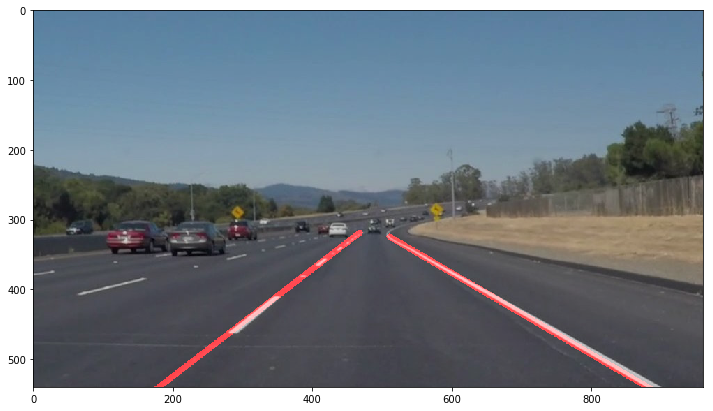

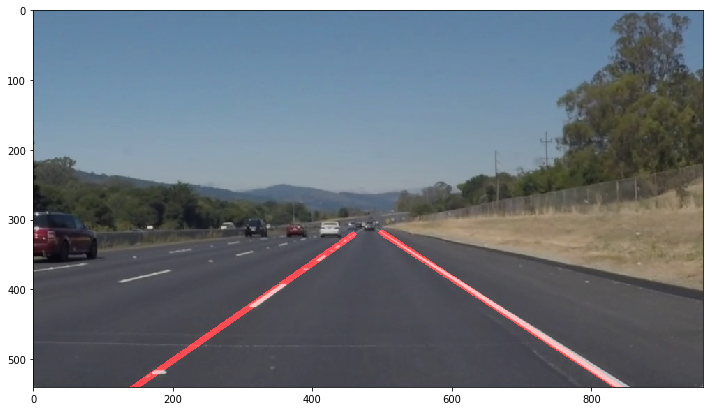

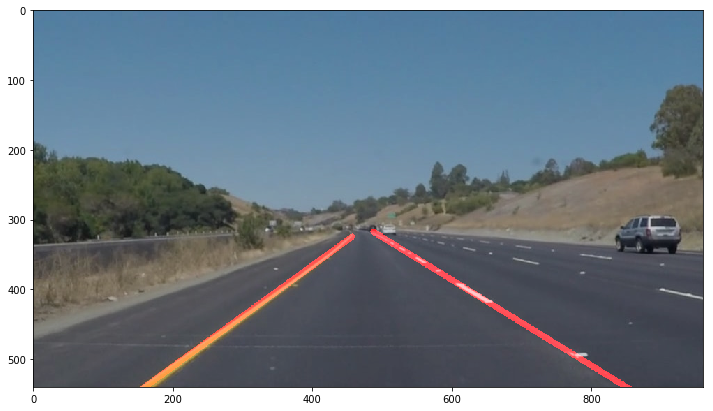

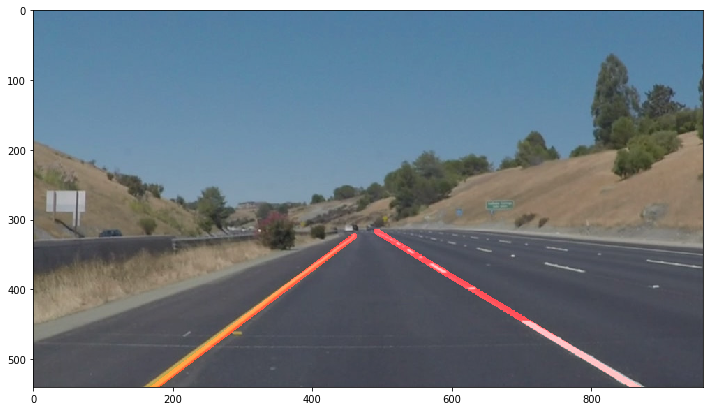

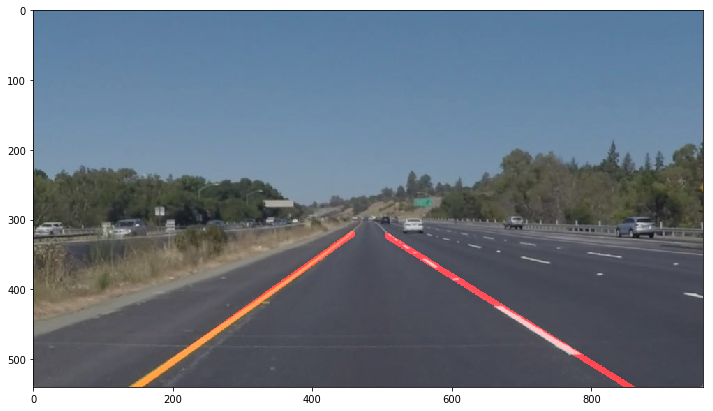

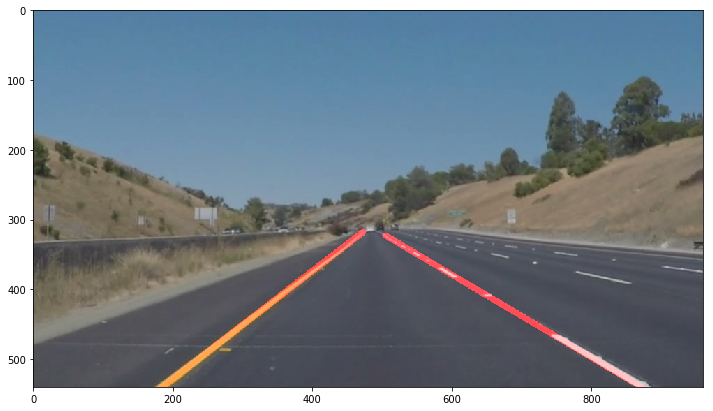

In [17]:
input_dir = "test_images"
output_dir = "test_images_output"
image_files = os.listdir(input_dir) 

for file in image_files: 
    # Load image. 
    if file.endswith('.jpg'): 
        image = mimg.imread(input_dir+'/'+file) 
        # Run lane-detection-pipeline on the image. 
        lanes_image = detect_lanes_pipeline(image)
        plt.figure(figsize=(12, 8))
        plt.imshow(lanes_image) 
        plt.show() 

## Test on Videos

Note: The following cell's output, which produces the videos, hasn't been run as there's a pending Moviepy error to be solved which occurs in my IPython notebook. Please find the processed videos in the parent directory of this project (solidWhiteRightOutput.mp4 and solidYellowLeftOutput.mp4), also attached as part of this notebok down below.

In [ ]:
white_output = 'solidWhiteRightOutput.mp4'
clip1 = VideoFileClip('test_videos/solidWhiteRight.mp4')
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(white_output, audio=False)

yellow_output = 'solidYellowLeftOutput.mp4'
clip2 = VideoFileClip('../test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
yellow_clip.write_videofile(yellow_output, audio=False)

In [20]:
import io
import base64
from IPython.display import HTML

video1 = io.open('solidWhiteRightOutput.mp4', 'r+b').read()
encoded = base64.b64encode(video1)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [21]:
video2 = io.open('solidYellowLeftOutput.mp4', 'r+b').read()
encoded = base64.b64encode(video2)
HTML(data='''<video alt="test" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))